In [1]:
from pathlib import Path

# Make the path object:
cache_path = Path('/tmp/cache')

# Just because we have made a cache path object doesn't mean that the directory
# we made exists; here we check if it exists and make the directory if not.
if not cache_path.exists():
    cache_path.mkdir()


In [2]:
from utilities import ls, crawl
import nibabel as nib

In [3]:
from cloudpathlib import S3Path, S3Client

client = S3Client(
    local_cache_dir=cache_path,
    no_sign_request=True)

hbn_base_path = S3Path(
    "s3://fcp-indi/",
    client=client)

In [4]:
base_path = Path('/home/jovyan/shared')
bids_path = hbn_base_path / "data" / "Projects" / "HBN" / "BIDS_curated" 
sub_code  = ["sub-NDARAA948VFH", "sub-NDARAB055BPR"]

qsi_path = base_path / 'diffusion_group_data' / 'results' / 'derivatives' / 'qsiprep'
print(qsi_path.exists())

True


In [92]:
# # Quickly look if BIDSified
# print(bids_path)
# for sub in sub_code: 
#     sub_path = bids_path / f'{sub}'
#     crawl(sub_path)

In [5]:
# Test with one subject
sub_code     = ['sub-NDARAA948VFH', 'sub-NDARAB055BPR']
bids_sub_idx = 0 
bids_sub     = f'{sub_code[bids_sub_idx]}'
print(bids_sub)

# Set variables on your file names
bids_ses   = 'HBNsiteRU'
bids_acq_anat= 'HCP'
bids_acq   = '64dir'
bids_space = 'T1w'
bids_desc  = 'preproc'

sub-NDARAA948VFH


In [6]:
# Set & load DWI file names
from dipy.io.image import load_nifti, save_nifti
# we might need T1w
t1_fname   = bids_path / bids_sub / f'ses-{bids_ses}' /'anat' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_anat}_T1w.nii.gz'
t1_data, t1_affine, t1_nii = load_nifti(t1_fname, return_img=True)

# Set raw DWI file names
dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.nii.gz'
bval_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.bval'
bvec_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.bvec'

# Set QSIprep output file names
dwi_fname_qsi  = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.nii.gz'
bval_fname_qsi = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.bval'
bvec_fname_qsi = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.bvec'

# Load volumes
from dipy.io.image import load_nifti, save_nifti
dwi_data, dwi_affine, dwi_nii = load_nifti(dwi_fname, return_img=True)
dwi_nii     = nib.load(dwi_fname)
dwi_data    = dwi_nii.get_fdata()
dwi_hdr     = dwi_nii.header

dwi_data_qsi, dwi_affine, dwi_nii = load_nifti(dwi_fname_qsi, return_img=True)
dwi_nii_qsi     = nib.load(dwi_fname_qsi)
dwi_data_qsi    = dwi_nii.get_fdata()
dwi_hdr_qsi     = dwi_nii.header
print('Volumes loaded')

Volumes loaded


In [10]:
# # returns dwi data size &  dimensions of each voxel
# print('DWI shape:')
# print(dwi_nii.shape)
# print('voxel dimensions:')
# print(dwi_nii.header.get_zooms()[:3])


In [7]:
# get bvals and bvecs in a diffusion gradient table
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

# Just as sanity check, see if gradient table looks reasonable
# get bvals and bvecs in a diffusion gradient table
bvals, bvecs = read_bvals_bvecs(bval_fname.fspath, bvec_fname.fspath) 
gtab = gradient_table(bvals, bvecs)
print('Gradients table info:')
print(gtab.info)

# Now get the diffusion gradient table for QSIprep
bvals_qsi, bvecs_qsi = read_bvals_bvecs(bval_fname_qsi.as_posix(), bvec_fname_qsi.as_posix())
print('Load QSIprep gradient table')   
gtab_qsi = gradient_table(bvals, bvecs)
print('QSIprep gradients table info:')
print(gtab_qsi.info)

# # Show gradient table info & bvals
# print('B-values')
# print(gtab.bvals)
# print('B-vectors')
# print(gtab.bvecs[:10, :])

Gradients table info:
B-values shape (129,)
         min 0.000000
         max 2000.000000
B-vectors shape (129, 3)
          min -0.996103
          max 0.999997

None
Load QSIprep gradient table
QSIprep gradients table info:
B-values shape (129,)
         min 0.000000
         max 2000.000000
B-vectors shape (129, 3)
          min -0.996103
          max 0.999997

None


Text(0.5, 1.0, '25th dir')

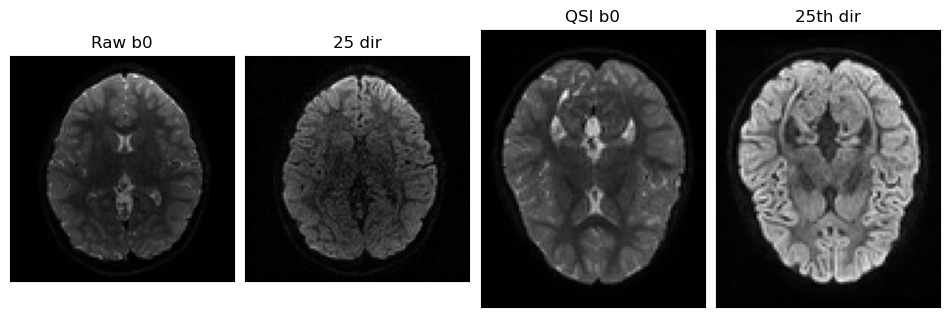

In [8]:
# Quickly visualize loaded volumes
import matplotlib.pyplot as plt
sli     = dwi_data.shape[2] // 2     # set a slice in the middle
sli_qsi = dwi_data_qsi.shape[2] // 2 # set a slice in the middle

# Check out both Raw & QSI data
# prepare to plot
fig1, ax = plt.subplots(1, 4, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(dwi_data[:, :, sli, 0].T, cmap='gray', origin='lower')
ax.flat[0].set_title('Raw b0')
ax.flat[1].imshow(dwi_data[:, :, sli, 25].T, cmap='gray', origin='lower')         # plot another volume in axial view
ax.flat[1].set_title('25 dir')
ax.flat[2].imshow(dwi_data_qsi[:, :, sli_qsi, 0].T, cmap='gray', origin='lower')
ax.flat[2].set_title('QSI b0')
ax.flat[3].imshow(dwi_data_qsi[:, :, sli_qsi, 25].T, cmap='gray', origin='lower') # plot another volume in axial view
ax.flat[3].set_title('25th dir')


In [9]:
#  Create the dwi masks
from dipy.segment.mask import median_otsu, multi_median

print('Getting dwi mask')
# Generates brian masks
dwi_data_masked, dwi_mask = median_otsu(dwi_data, vol_idx = range(10, 50),
                                        median_radius = 5, numpass = 3,
                                        autocrop = False, dilate = 2)
print('Getting QSI prep mask')
dwi_data_masked_qsi, dwi_mask_qsi = median_otsu(dwi_data_qsi, vol_idx = range(10, 50),
                                        median_radius = 3, numpass = 2,
                                        autocrop = False, dilate = 2)


Getting dwi mask
Getting QSI prep mask


Text(0.5, 1.0, 'QSI mask')

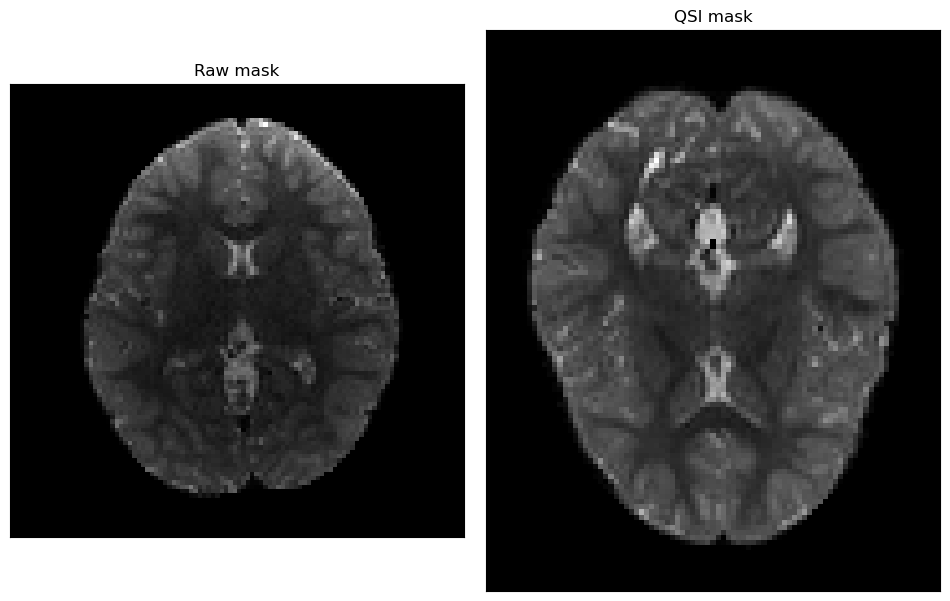

In [10]:
# quickly visualize the results to evaluate whether to adjust mask params (?)
sli     = dwi_data_masked.shape[2] // 2
sli_qsi = dwi_data_masked_qsi.shape[2] // 2

# Plot both raw & QSI volumes after clipping mask
fig1, ax = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(dwi_data_masked[:, :, sli, 0].T, cmap='gray', origin='lower')
ax.flat[0].set_title('Raw mask')
ax.flat[1].imshow(dwi_data_masked_qsi[:, :, sli_qsi, 0].T, cmap='gray', origin='lower')
ax.flat[1].set_title('QSI mask')


In [57]:
# Let's do some motion correction first
from dipy.align import motion_correction
print('Performing motion correction')
dwi_corrected_nii, reg_afines = motion_correction(dwi_data_masked, gtab, dwi_affine)


Text(0.5, 1.0, 'Motion corrected')

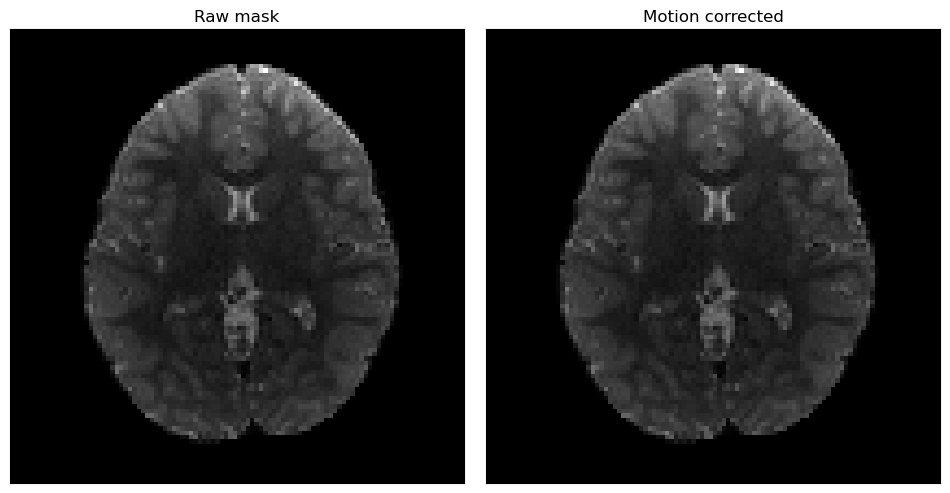

In [38]:
# Plot both raw & QSI volumes after clipping mask
# first get the data from the corrected nii
dwi_corrected = dwi_corrected_nii.dataobj

#Now plot
fig1, ax = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(dwi_data_masked[:, :, sli, 0].T, cmap='gray', origin='lower')
ax.flat[0].set_title('Raw mask')
ax.flat[1].imshow(dwi_data_corrected[:, :, sli, 0].T, cmap='gray', origin='lower')
ax.flat[1].set_title('Motion corrected')


In [39]:
# Denoise
from dipy.denoise.patch2self import patch2self
# Total time taken for Patch2Self is ~22 mins
print('Denoising')
dwi_den = patch2self(dwi_corrected, bvals, model='ols', verbose=True,
                          shift_intensity=True,
                          clip_negative_vals=False,
                          b0_threshold=50)

Denoising
b0 denoising skipped...
Denoised DWI Volume:  0
Denoised DWI Volume:  1
Denoised DWI Volume:  2
Denoised DWI Volume:  3
Denoised DWI Volume:  4
Denoised DWI Volume:  5
Denoised DWI Volume:  6
Denoised DWI Volume:  7
Denoised DWI Volume:  8
Denoised DWI Volume:  9
Denoised DWI Volume:  10
Denoised DWI Volume:  11
Denoised DWI Volume:  12
Denoised DWI Volume:  13
Denoised DWI Volume:  14
Denoised DWI Volume:  15
Denoised DWI Volume:  16
Denoised DWI Volume:  17
Denoised DWI Volume:  18
Denoised DWI Volume:  19
Denoised DWI Volume:  20
Denoised DWI Volume:  21
Denoised DWI Volume:  22
Denoised DWI Volume:  23
Denoised DWI Volume:  24
Denoised DWI Volume:  25
Denoised DWI Volume:  26
Denoised DWI Volume:  27
Denoised DWI Volume:  28
Denoised DWI Volume:  29
Denoised DWI Volume:  30
Denoised DWI Volume:  31
Denoised DWI Volume:  32
Denoised DWI Volume:  33
Denoised DWI Volume:  34
Denoised DWI Volume:  35
Denoised DWI Volume:  36
Denoised DWI Volume:  37
Denoised DWI Volume:  38
D

Text(0.5, 1.0, 'Residuals')

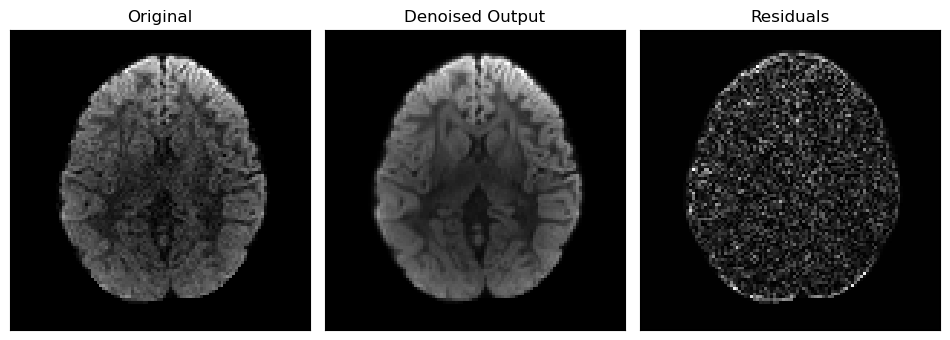

In [42]:
# Now plot before and after to see the denoising
import numpy as np
gra  = 24  # pick out a random volume for a particular gradient direction
orig = dwi_data_masked[:, :, sli, gra]
den  = dwi_den[:, :, sli, gra]

fig1, ax = plt.subplots(1, 3, figsize = (12, 12), subplot_kw = {'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace = 0.3, wspace = 0.05)

# Compute residuals
rms_diff = np.sqrt((orig - den) ** 2)
# plot original, denoised, and residuals
ax.flat[0].imshow(orig.T, cmap = 'gray', interpolation = 'none', origin = 'lower')
ax.flat[0].set_title('Original')
ax.flat[1].imshow(den.T, cmap = 'gray', interpolation = 'none', origin = 'lower')
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap = 'gray', interpolation = 'none', origin = 'lower')
ax.flat[2].set_title('Residuals')

Text(0.5, 1.0, 'QSI mask')

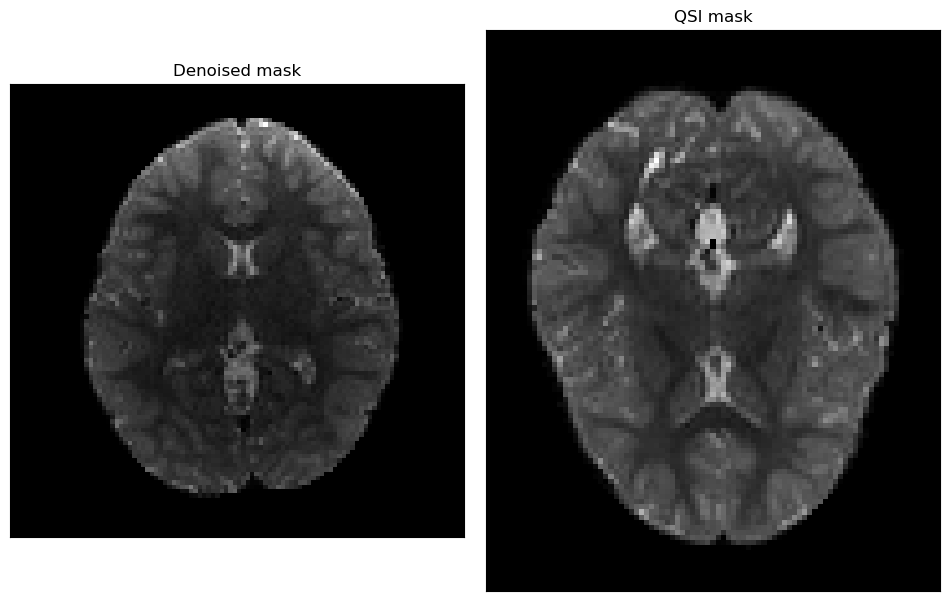

In [43]:
# Now compare Simple vs QSI preproc
fig1, ax = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(dwi_den[:, :, sli, 0].T, cmap='gray', origin='lower')
ax.flat[0].set_title('Denoised mask')
ax.flat[1].imshow(dwi_data_masked_qsi[:, :, sli_qsi, 0].T, cmap='gray', origin='lower')
ax.flat[1].set_title('QSI mask')


In [44]:
# Fitting tensor model
from dipy.io.utils    import nifti1_symmat
from dipy.reconst.dti import (TensorModel, color_fa, fractional_anisotropy,
                              lower_triangular, geodesic_anisotropy,
                              mean_diffusivity, axial_diffusivity,
                              radial_diffusivity, lower_triangular)
from dipy.segment.tissue import TissueClassifierHMRF

print('Fitting tensor model on simple preproc')
ten_model  = TensorModel(gtab)
tenfit     = ten_model.fit(dwi_den)
print('Fitting tensor model on QSI prep')
ten_model  = TensorModel(gtab_qsi)
tenfit_qsi = ten_model.fit(dwi_data_masked_qsi)


Fitting tensor model on simple preproc
Fitting tensor model on QSI prep


In [47]:
# # Generate WM mask w/ FA thresholding    | NOT USING WM MASK
# import numpy as np

# FA      = fractional_anisotropy(tenfit.evals)
# FA[np.isnan(FA)] = 0
# FA      = np.clip(FA, 0, 1)
# tensor_vals = lower_triangular(tenfit.quadratic_form)   # recover the covariance matrix
# ten_nii = nifti1_symmat(tensor_vals, affine=dwi_affine)     # Get a nii with a symmetric matrix intent

# FA_qsi      = fractional_anisotropy(tenfit_qsi.evals)
# FA_qsi[np.isnan(FA_qsi)] = 0
# FA_qsi      = np.clip(FA_qsi, 0, 1)
# tensor_vals_qsi = lower_triangular(tenfit_qsi.quadratic_form)   # recover the covariance matrix
# ten_nii_qsi     = nifti1_symmat(tensor_vals_qsi, affine=dwi_affine) # Get a nii with a symmetric matrix intent

# # potentially test to improve WM mask?
# # wm_mask = (np.logical_or(FA >= 0.4, (np.logical_and(FA >= 0.15, MD >= 0.0011))))

# wm_FA     = FA > 0.12
# wm_FA_qsi = FA_qsi > 0.12
# print(wm_FA.shape)
# print(wm_FA.shape)

(104, 104, 72)


In [48]:
# Estimate fiber orientations at the voxel level
from dipy.direction.peaks import peaks_from_model
from dipy.reconst import csdeconv, shm, dti

dti_model = dti.TensorModel(gtab)
# run constrained spherical deconvolution model
response, ratio = csdeconv.auto_response_ssst(gtab, dwi_den, roi_radii=10, fa_thr=0.7)
csd_model       = csdeconv.ConstrainedSphericalDeconvModel(gtab, response)
# csd_fit         = csd_model.fit(dwi_data_masked, mask=wm_FA)

dti_model_qsi = dti.TensorModel(gtab_qsi)
# run constrained spherical deconvolution model
response, ratio = csdeconv.auto_response_ssst(gtab_qsi, dwi_data_masked_qsi, roi_radii=10, fa_thr=0.7)
csd_model_qsi   = csdeconv.ConstrainedSphericalDeconvModel(gtab_qsi, response)
# csd_fit         = csd_model.fit(dwi_data_masked, mask=wm_FA_qsi) # perhaps also test (?)

Text(0.5, 1.0, 'CSO voxel (?)')

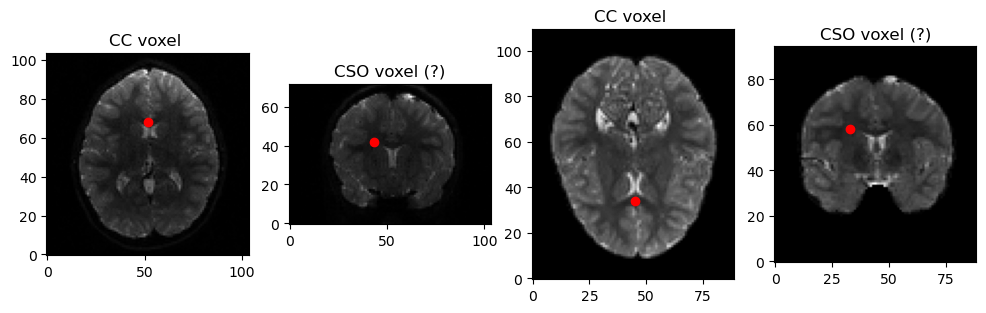

In [49]:
# Look at which voxel to test on
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow((dwi_data[:, :, 38, 0].astype('float')).T, cmap='gray', origin='lower')
ax[0].scatter(52, 68, c='r')
ax[0].set_title('CC voxel ')
# 43,65,42
ax[1].imshow((dwi_data[:, 65, :, 0].astype('float')).T, cmap='gray', origin='lower')
ax[1].scatter(43, 42, c='r')
ax[1].set_title('CSO voxel')

ax[2].imshow((dwi_data_masked_qsi[:, :, 49, 0].astype('float')).T, cmap='gray', origin='lower')
ax[2].scatter(45, 34, c='r')
ax[2].set_title('CC voxel ')
# 33 46 57
ax[3].imshow((dwi_data_masked_qsi[:, 46, :, 0].astype('float')).T, cmap='gray', origin='lower')
ax[3].scatter(33, 58, c='r')
ax[3].set_title('CSO voxel')

In [52]:
# Setting voxels to test recon models
cc_vox      = dwi_data[52, 68, 38]
cso_vox     = dwi_data[43, 65, 42]

cc_vox_qsi  = dwi_data_masked_qsi[45, 34, 49]
cso_vox_qsi = dwi_data_masked_qsi[33, 46, 58]

# Compute 8-fold cross-validation for
# First for corpus callosum
# Simple preproc
import dipy.reconst.cross_validation as xval
dti_cc    = xval.kfold_xval(dti_model, cc_vox, 8)
csd_cc    = xval.kfold_xval(csd_model, cc_vox, 8, response)
# QSI preproc
import dipy.reconst.cross_validation as xval
dti_cc_qsi= xval.kfold_xval(dti_model_qsi, cc_vox_qsi, 8)
csd_cc_qsi= xval.kfold_xval(csd_model_qsi, cc_vox_qsi, 8, response)

# # Now for centrum semiovale
# # Simple preproc:
dti_cso   = xval.kfold_xval(dti_model, cso_vox, 8)
csd_cso   = xval.kfold_xval(csd_model, cso_vox, 8, response)
# # QSI preproc:
dti_cso_qsi  = xval.kfold_xval(dti_model_qsi, cso_vox_qsi, 8)
csd_cso_qsi  = xval.kfold_xval(csd_model_qsi, cso_vox_qsi, 8, response)

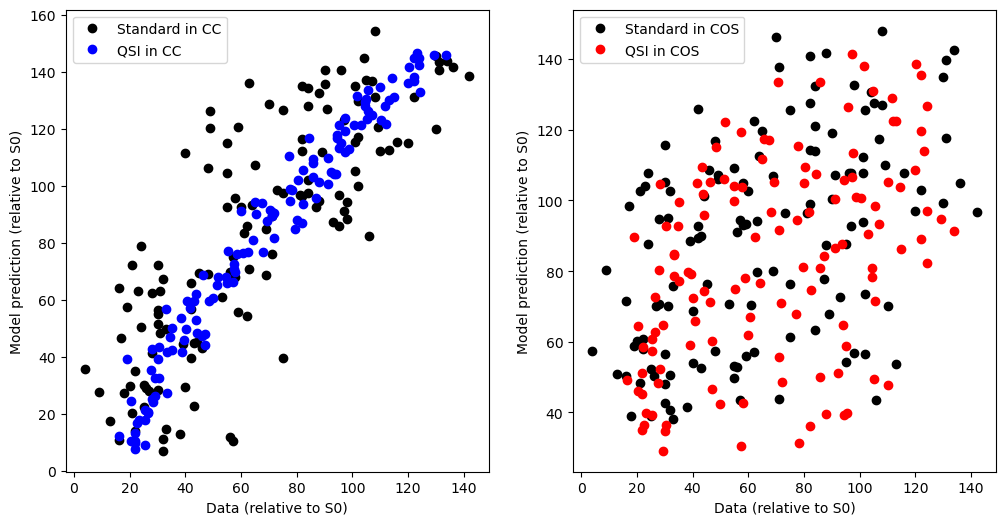

In [53]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches([12, 6])
ax[0].plot(cc_vox[gtab.b0s_mask == 0], dti_cc[gtab.b0s_mask == 0], 'o',
           color='k', label='Standard in CC')
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='QSI in CC')
ax[1].plot(cc_vox[gtab.b0s_mask == 0], dti_cso[gtab.b0s_mask == 0], 'o',
           color='k', label='Standard in COS')
ax[1].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='QSI in COS')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

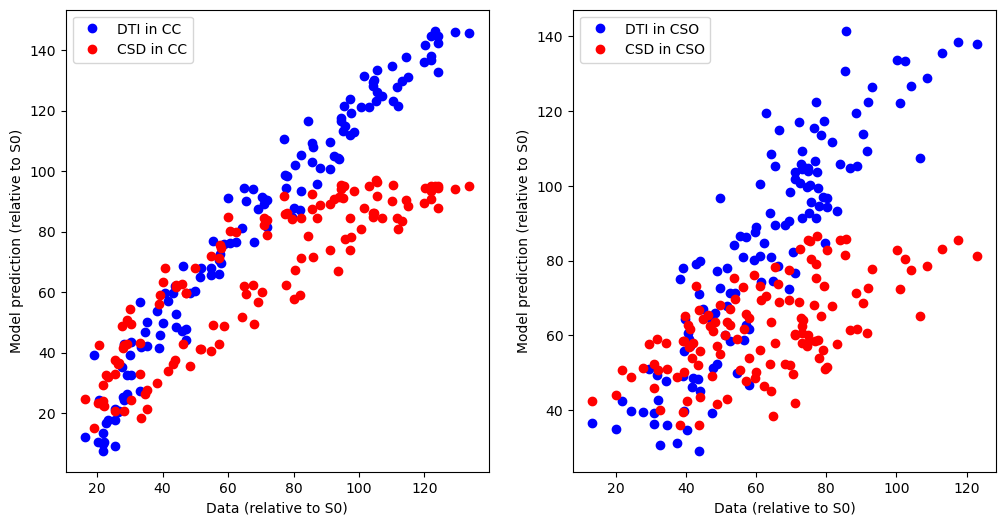

In [54]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches([12, 6])
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='DTI in CC')
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='CSD in CC')
ax[1].plot(cso_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='DTI in CSO')
ax[1].plot(cso_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='CSD in CSO')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

In [56]:
# Now let's compute the COD
import scipy.stats as stats

cc_dti_r2  = stats.pearsonr(cc_vox[gtab.b0s_mask == 0], dti_cc[gtab.b0s_mask == 0])[0]**2
cc_csd_r2  = stats.pearsonr(cc_vox[gtab.b0s_mask == 0], csd_cc[gtab.b0s_mask == 0])[0]**2
cso_dti_r2 = stats.pearsonr(cso_vox[gtab.b0s_mask == 0], dti_cso[gtab.b0s_mask == 0])[0]**2
cso_csd_r2 = stats.pearsonr(cso_vox[gtab.b0s_mask == 0], csd_cso[gtab.b0s_mask == 0])[0]**2

cc_dti_r2_qsi  = stats.pearsonr(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cc_csd_r2_qsi  = stats.pearsonr(cc_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cc_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cso_dti_r2_qsi = stats.pearsonr(cso_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cso_csd_r2_qsi = stats.pearsonr(cso_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cso_qsi[gtab_qsi.b0s_mask == 0])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2, cc_csd_r2, cso_dti_r2, cso_csd_r2))

print("QSI Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "QSI Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2_qsi, cc_csd_r2_qsi, cso_dti_r2_qsi, cso_csd_r2_qsi))

Corpus callosum
DTI R2 : 0.645348748746717
CSD R2 : 0.5389500898835191

Centrum Semiovale
DTI R2 : 0.5363238598108593
CSD R2 : 0.15137664304671253

QSI Corpus callosum
DTI R2 : 0.9569682960253321
CSD R2 : 0.7787038153091427

QSI Centrum Semiovale
DTI R2 : 0.79458075847158
CSD R2 : 0.35759230281547005

